## Данные

Предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
!pip install category_encoders
from category_encoders.one_hot import OneHotEncoder

In [ ]:
data = pd.read_csv("data.adult.csv")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


В данном датасете пропущенные значения обозначены как "?".


In [ ]:
#удалим объекты с пропусками
for col in data.columns:
  data.loc[data[col] == "?", col] = None
data = data.dropna(axis = 0)

In [ ]:
#преобразуем целевую переменную к бинарному формату, выделим ее и удалим ее из датасета
data['y'] = np.where(data['>50K,<=50K']==">50K", 1, 0)
y = data['y']
data = data.drop(['>50K,<=50K'],axis=1)
data = data.drop(['y'],axis=1)

In [ ]:
#выделим вещественные признаки
float_columns = data.columns[data.dtypes == 'float64'].tolist()
X = data[float_columns]

## Обучение классификаторов на вещественных признаках


In [ ]:
#подберем наилучший параметр n_neighbors для KNN с помощью GridSearchCV
neigh = KNeighborsClassifier()
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(neigh, params, cv=5, scoring='roc_auc')
grid.fit(X, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.6406685362017244
best params: {'n_neighbors': 4}


In [ ]:
#Оптимальное значение параметра n_neighbors получилось равным 4. Значение ROC-AUC приблизительно равно 0.64.

In [ ]:
#подберем наилучший параметр max_depth для DecisionTree с помощью GridSearchCV
dtc = DecisionTreeClassifier()
params = {'max_depth':[None,1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(dtc, params, cv=5, scoring='roc_auc')
grid.fit(X, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8415312329417738
best params: {'max_depth': 7}


In [ ]:
#Оптимальное значение параметра max_depth получилось равным 7. Значение ROC-AUC приблизительно равно 0.84.

In [ ]:
#подберем наилучший параметр loss для SGD Linear Classifier с помощью GridSearchCV
sgd = SGDClassifier()
params = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(sgd, params, cv=5, scoring='roc_auc')
grid.fit(X, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

best score: 0.6207066635512728
best params: {'loss': 'log_loss'}


In [ ]:
#Оптимальным параметром loss является log_loss. Значение ROC-AUC приблизительно равно 0.62.

In [ ]:
#подберем параметр n_estimators для RandomForest, при котором качество на кросс-валидации стабилизируется
for a in np.arange(10, 101, 10):
    rfc = RandomForestClassifier(n_estimators = a)
    cv_res = cross_validate(rfc, X, y, scoring='roc_auc', cv=5)
    print('n_estimators =', a)
    print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

n_estimators = 10
mean test ROC-AUC = 0.792407779250264
n_estimators = 20
mean test ROC-AUC = 0.8050167265052449
n_estimators = 30
mean test ROC-AUC = 0.8111011878581899
n_estimators = 40
mean test ROC-AUC = 0.8137306517356009
n_estimators = 50
mean test ROC-AUC = 0.8144311784675977
n_estimators = 60
mean test ROC-AUC = 0.8146440113336977
n_estimators = 70
mean test ROC-AUC = 0.815797408606857
n_estimators = 80
mean test ROC-AUC = 0.8177716601850742
n_estimators = 90
mean test ROC-AUC = 0.8175550941387304
n_estimators = 100
mean test ROC-AUC = 0.8178384753224666


In [ ]:
#При n_estimators = 30 качество стабилизируется приблизительно на ROC-AUC = 0.81.

(array([694., 640., 751., 787., 750., 800., 820., 818., 858., 873., 824.,
        829., 754., 710., 707., 515., 611., 464., 399., 336., 333., 271.,
        214., 169., 105.,  85.,  59.,  47.,  35.,  32.,  16.,  13.,   4.,
          7.,   1.,  16.]),
 array([17.        , 19.02777778, 21.05555556, 23.08333333, 25.11111111,
        27.13888889, 29.16666667, 31.19444444, 33.22222222, 35.25      ,
        37.27777778, 39.30555556, 41.33333333, 43.36111111, 45.38888889,
        47.41666667, 49.44444444, 51.47222222, 53.5       , 55.52777778,
        57.55555556, 59.58333333, 61.61111111, 63.63888889, 65.66666667,
        67.69444444, 69.72222222, 71.75      , 73.77777778, 75.80555556,
        77.83333333, 79.86111111, 81.88888889, 83.91666667, 85.94444444,
        87.97222222, 90.        ]),
 <BarContainer object of 36 artists>)

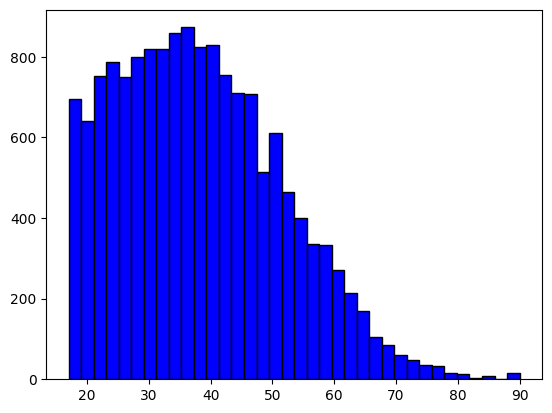

In [ ]:
#построим гистограмму для переменнной age
plt.hist(X['age'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

(array([1.424e+03, 1.333e+03, 2.427e+03, 2.780e+03, 2.966e+03, 1.448e+03,
        9.820e+02, 7.700e+02, 4.830e+02, 3.270e+02, 1.620e+02, 8.800e+01,
        4.700e+01, 3.500e+01, 2.800e+01, 1.400e+01, 9.000e+00, 8.000e+00,
        1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00]),
 array([  19302.        ,   60007.63888889,  100713.27777778,
         141418.91666667,  182124.55555556,  222830.19444444,
         263535.83333333,  304241.47222222,  344947.11111111,
         385652.75      ,  426358.38888889,  467064.02777778,
         507769.66666667,  548475.30555556,  589180.94444444,
         629886.58333333,  670592.22222222,  711297.86111111,
         752003.5       ,  792709.13888889,  833414.77777778,
         874120.41666667,  914826.05555556,  955531.69444444,
         996237.33333333, 1036942.97222222, 1077648.611111

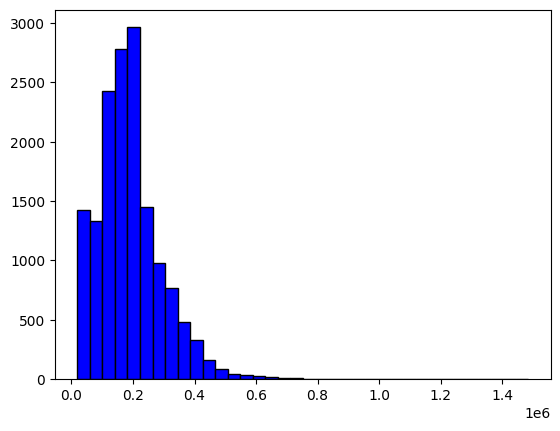

In [ ]:
#построим гистограмму для переменнной fnlwgt
plt.hist(X['fnlwgt'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

(array([1.4182e+04, 4.4100e+02, 3.2100e+02, 6.8000e+01, 1.5000e+01,
        2.0800e+02, 1.0000e+00, 1.8000e+01, 0.0000e+00, 9.0000e+00,
        1.6000e+01, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.6000e+01]),
 array([    0.  ,  2777.75,  5555.5 ,  8333.25, 11111.  , 13888.75,
        16666.5 , 19444.25, 22222.  , 24999.75, 27777.5 , 30555.25,
        33333.  , 36110.75, 38888.5 , 41666.25, 44444.  , 47221.75,
        49999.5 , 52777.25, 55555.  , 58332.75, 61110.5 , 63888.25,
        66666.  , 69443.75, 72221.5 , 74999.25, 77777.  , 80554.75,
        83332.5 , 86110.25, 88888.  , 91665.75, 94443.5 , 97221.25,
        99999.  ]),
 <BarContainer object of 36 artists>)

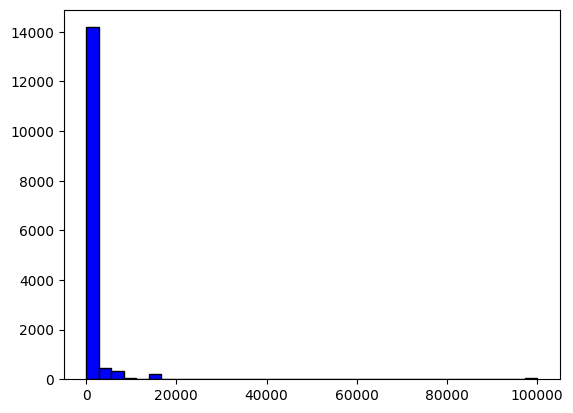

In [ ]:
#построим гистограмму для переменнной capital-gain
plt.hist(X['capital-gain'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

In [ ]:
#Распределение признаков age, fnlwgt, capital-gain имеет правостороннюю ассиметрию.
#Также видно, что одни числовые признаки имеют бОльшие числовые значения, чем другие (например, значения признака age явно больше значений признака fnlwgt).
#Это может приводить к доминированию признаков с бОльшими значениями.
#Масштабирование может решить вышеописанную проблему.

In [ ]:
#создадим класс для масштабирования признаков
class CustomScaler(TransformerMixin):
    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        num_cols = X.copy()[self.cols]
        self.scaler.fit(num_cols)
        return self
    def transform(self, X, y=None):
        X_res = X.copy()
        num_cols_tr = self.scaler.transform(X_res[self.cols])
        for i, col in enumerate(self.cols):
            X_res[col] = num_cols_tr[:,i]
        return X_res

#масштабируем вещественные признаки
X_scaled = CustomScaler(X.columns).fit_transform(X)

In [ ]:
#подберем наилучший параметр n_neighbors для KNN с помощью GridSearchCV
neigh = KNeighborsClassifier()
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(neigh, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8083485930057266
best params: {'n_neighbors': 10}


In [ ]:
#Оптимальное значение параметра n_neighbors получилось равным 10. Значение ROC-AUC приблизительно равно 0.81.

In [ ]:
#подберем наилучший параметр max_depth для DecisionTree с помощью GridSearchCV
dtc = DecisionTreeClassifier()
params = {'max_depth':[None,1,2,3,4,5,6,7,8,9,10]}
grid = GridSearchCV(dtc, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8412486625133615
best params: {'max_depth': 7}


In [ ]:
#Оптимальное значение параметра max_depth получилось равным 7. Значение ROC-AUC приблизительно равно 0.84.

In [ ]:
#подберем наилучший параметр loss для SGD Linear Classifier с помощью GridSearchCV
sgd = SGDClassifier()
params = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']}
grid = GridSearchCV(sgd, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.822732301072552
best params: {'loss': 'log_loss'}


In [ ]:
#Оптимальным параметром loss является log_loss. Значение ROC-AUC приблизительно равно 0.82.

In [ ]:
#подберем параметр n_estimators для RandomForest, при котором качество на кросс-валидации стабилизируется
for a in np.arange(10, 101, 10):
    rfc = RandomForestClassifier(n_estimators = a)
    cv_res = cross_validate(rfc, X_scaled, y, scoring='roc_auc', cv=5)
    print('n_estimators =', a)
    print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

n_estimators = 10
mean test ROC-AUC = 0.796470205951327
n_estimators = 20
mean test ROC-AUC = 0.8054678847204357
n_estimators = 30
mean test ROC-AUC = 0.810412210860564
n_estimators = 40
mean test ROC-AUC = 0.8128591360352928
n_estimators = 50
mean test ROC-AUC = 0.8142124682288016
n_estimators = 60
mean test ROC-AUC = 0.81508751829084
n_estimators = 70
mean test ROC-AUC = 0.8165071953324553
n_estimators = 80
mean test ROC-AUC = 0.8165707876595321
n_estimators = 90
mean test ROC-AUC = 0.8170985612167065
n_estimators = 100
mean test ROC-AUC = 0.818328622494235


In [ ]:
#При n_estimators = 30 качество стабилизируется приблизительно на ROC-AUC = 0.81.

In [ ]:
#Качество алгоритмов KNN, SGD Linear Classifier улучшилось. Качество алгоритмов DecisionTree и Random Forest почти не изменилось.

In [ ]:
#подберем наилучшую комбинацию параметров n_neighbors и metric для KNN с помощью GridSearchCV
neigh = KNeighborsClassifier()
params = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10], 'metric':['minkowski','cityblock','cosine','euclidean']}
grid = GridSearchCV(neigh, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8126035859327416
best params: {'metric': 'cityblock', 'n_neighbors': 10}


In [ ]:
#Оптимальными значениями параметров получились n_neighbors = 10, metric = cityblock. Значение ROC-AUC приблизительно равно 0.81.

In [ ]:
#подберем наилучшие параметры max_depth и criterion для DecisionTree с помощью GridSearchCV
dtc = DecisionTreeClassifier()
params = {'max_depth':[None,1,2,3,4,5,6,7,8,9,10], 'criterion':['gini', 'entropy', 'log_loss']}
grid = GridSearchCV(dtc, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8426286932904967
best params: {'criterion': 'log_loss', 'max_depth': 8}


In [ ]:
#Оптимальными значениями параметров получились max_depth = 8, criterion = log_loss. Значение ROC-AUC приблизительно равно 0.84.

In [ ]:
#подберем наилучшие параметры loss и penalty для SGD Linear Classifier с помощью GridSearchCV
sgd = SGDClassifier()
params = {'loss':['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'penalty':['l2', 'l1', 'elasticnet', None]}
grid = GridSearchCV(sgd, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.8223568062353355
best params: {'loss': 'log_loss', 'penalty': 'elasticnet'}


In [ ]:
#Оптимальными значениями параметров получились loss = log_loss, penalty = elasticnet. Значение ROC-AUC приблизительно равно 0.82.

In [ ]:
#подберем наилучшие параметры criterion и max_features для RandomForest с помощью GridSearchCV
rfc = RandomForestClassifier(n_estimators = 30)
params = {'criterion':['gini','entropy', 'log_loss'], 'max_features':['sqrt', 'log2', None]}
grid = GridSearchCV(rfc, params, cv=5, scoring='roc_auc')
grid.fit(X_scaled, y)
print('best score:', grid.best_score_)
print('best params:', grid.best_params_)

best score: 0.812847825858336
best params: {'criterion': 'entropy', 'max_features': None}


In [ ]:
#Оптимальными значениями параметров получились criterion = entropy, max_features = None. Значение ROC-AUC приблизительно равно 0.81.

In [ ]:
#Наилучшее качество показал алгоритм DecisionTree.

## Добавление категориальных признаков в модели


In [ ]:
#выделим категориальные признаки
cat_columns = data.columns[data.dtypes == 'object']
X_cat = data[cat_columns]

In [ ]:
#преобразуем категориальные признаки
one_hot_enc = OneHotEncoder()
X_cat = one_hot_enc.fit_transform(X_cat)

In [ ]:
#добавим к вещественным признакам категориальные
X_float_cat = pd.concat([X_scaled, X_cat], axis=1)

In [ ]:
#обучим алгоритм KNN и посмотрим на качество
neigh = KNeighborsClassifier(n_neighbors = 10, metric = 'cityblock')
cv_res = cross_validate(neigh, X_float_cat, y, scoring='roc_auc', cv=5)
print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

mean test ROC-AUC = 0.874119738479291


In [ ]:
#Получилось приблизительно ROC-AUC = 0.87. Качество улучшилось.

In [ ]:
#обучим алгоритм DecisionTree и посмотрим на качество
dtc = DecisionTreeClassifier(max_depth = 8, criterion = 'log_loss')
cv_res = cross_validate(dtc, X_float_cat, y, scoring='roc_auc', cv=5)
print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

mean test ROC-AUC = 0.889782438437299


In [ ]:
#Получилось приблизительно ROC-AUC = 0.89. Качество улучшилось.

In [ ]:
#обучим алгоритм SGD Linear Classifier и посмотрим на качество
sgd = SGDClassifier(loss = 'log_loss', penalty = 'elasticnet')
cv_res = cross_validate(sgd, X_float_cat, y, scoring='roc_auc', cv=5)
print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

mean test ROC-AUC = 0.8982268655991744


In [ ]:
#Получилось приблизительно ROC-AUC = 0.90. Качество улучшилось.

In [ ]:
#обучим алгоритм RandomForest и посмотрим на качество
rfc = RandomForestClassifier(n_estimators = 30, criterion = 'entropy', max_features = None)
cv_res = cross_validate(rfc, X_float_cat, y, scoring='roc_auc', cv=5)
print(f"mean test ROC-AUC = {cv_res['test_score'].mean()}")

mean test ROC-AUC = 0.8950266652269752


In [ ]:
#Получилось приблизительно ROC-AUC = 0.90. Качество улучшилось.

In [ ]:
#Наилучший классификатор - SGD Linear Classifier.